In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib as mpl
import numpy as np
import scipy.signal

#%matplotlib notebook
%matplotlib inline
mpl.rcParams['figure.figsize'] = (18, 6)


In [5]:
import os, glob, sys

files = glob.glob('csv/c*.csv')
# make sure we get a consistent order.
files.sort()
data = []
count = 0
for name in files: 
    try:
        print " reading  file " + name
        thisfile = np.loadtxt(name, skiprows=1, usecols=tuple((0,1,2,3,4)),delimiter=",")
        thisfile = scipy.signal.decimate(thisfile, 10, n=None, ftype='iir', axis=0, zero_phase=True)
        data.append(thisfile)
    except IOError as exc:
        if exc.errno != errno.EISDIR:
            pass
        else: # Do not fail if a directory is found, just ignore it.
            raise exc # Propagate other kinds of IOError.
#c = np.loadtxt("c18-06-24-12_00.csv",skiprows=1,usecols=(0,1,2,3,4),delimiter=",")
#c = np.loadtxt("c18-07-01-12_00.csv",skiprows=1,usecols=(0,1,2,3,4),delimiter=",")
#print(c.shape)
    count += 1
    if count > 100:
        break
print "done"

 reading  file csv\c18-06-22-12_00.csv
 reading  file csv\c18-06-23-12_00.csv
 reading  file csv\c18-06-24-12_00.csv
 reading  file csv\c18-06-25-12_00.csv
 reading  file csv\c18-06-26-12_00.csv
 reading  file csv\c18-06-27-12_00.csv
 reading  file csv\c18-06-28-12_00.csv
 reading  file csv\c18-06-29-12_00.csv
 reading  file csv\c18-06-30-12_00.csv
 reading  file csv\c18-07-01-12_00.csv
 reading  file csv\c18-07-02-12_00.csv
 reading  file csv\c18-07-03-12_00.csv
 reading  file csv\c18-07-04-12_00.csv
 reading  file csv\c18-07-05-12_00.csv
 reading  file csv\c18-07-06-12_00.csv
 reading  file csv\c18-07-07-12_00.csv
 reading  file csv\c18-07-08-12_00.csv
 reading  file csv\c18-07-09-12_00.csv
 reading  file csv\c18-07-10-12_00.csv
 reading  file csv\c18-07-11-12_00.csv
 reading  file csv\c18-07-12-12_00.csv
 reading  file csv\c18-07-13-12_00.csv
 reading  file csv\c18-07-14-12_00.csv
 reading  file csv\c18-07-15-12_00.csv
 reading  file csv\c18-07-16-12_00.csv
 reading  file csv\c18-07

In [6]:
# massage data, correct for DST
day = 7420 # this many indexes in a day, roughly

hour = int(float(day)/24.) # chop this off to correct for dst
newd = []
d = data[0]
oldt = d[0,0]
dst = True
for i, d in enumerate(data[:]):
    if d.shape[0] > 7420:
        #print d.shape
        t = d[0,0]
        print(t -oldt)
        if (t - oldt) > 88000 and (t - oldt < 90000):
            dst = False
        if dst:
            # add in an hour to time 
            newd.append(d[hour:7420,:])
            print("DST")
        else:
            newd.append(d[0:7420-hour,:])
        oldt = t
            
del data
#print newd[0]
                    

0.0
DST
85400.5371696949
DST
85418.2073469162
DST
85414.85457324982
DST
85405.48204135895
DST
85416.13233852386
DST
85402.60904598236
DST
85410.20818066597
DST
85421.52845478058
DST
85399.5645647049
DST
170839.68719673157
DST
85395.65706181526
DST
85405.18755626678
DST
85428.35039806366
DST
85398.70122623444
DST
85415.22147083282
DST
85416.46578884125
DST
85416.86077237129
DST
85400.23373889923
DST
85410.0626783371
DST
85421.24379634857
DST
85407.31563282013
DST
85405.79786229134
DST
85420.5036020279
DST
85403.76998233795
DST
85411.01527309418
DST
85413.29450893402
DST
85407.22319889069
DST
85414.63500523567
DST
85404.84235668182
DST
85407.17636013031
DST
85418.90199184418
DST
85408.3168516159
DST
85410.54541707039
DST
85406.41043567657
DST
85407.54724216461
DST
85423.58877849579
DST
85400.93582248688
DST
85410.48753261566
DST
85426.46664357185
DST
85394.1851644516
DST
85417.21783161163
DST
85426.58041286469
DST
85392.83775043488
DST
85408.31022572517
DST
85433.73542499542
DST
85391.46

In [7]:
#https://gist.github.com/edouardp/3089602

# Assumes you have a np.array((height,width,3), dtype=float) as your HDR image

def write_hdr(image, fname):
    f = open(fname, "wb")
    f.write("#?RADIANCE\n# Made with Python & Numpy\nFORMAT=32-bit_rle_rgbe\n\n")
    f.write("-Y {0} +X {1}\n".format(image.shape[0], image.shape[1]))

    brightest = np.maximum(np.maximum(image[...,0], image[...,1]), image[...,2])
    mantissa = np.zeros_like(brightest)
    exponent = np.zeros_like(brightest)
    np.frexp(brightest, mantissa, exponent)
    scaled_mantissa = mantissa * 256.0 / brightest
    rgbe = np.zeros((image.shape[0], image.shape[1], 4), dtype=np.uint8)
    rgbe[...,0:3] = np.around(image[...,0:3] * scaled_mantissa[...,None])
    rgbe[...,3] = np.around(exponent + 128)

    rgbe.flatten().tofile(f)
    f.close()

In [8]:
#decimate data
import scipy

decd = []

for i, d in enumerate(newd[:]):
    q = d[:,1:4]
    q = q/np.max(np.max(q))
    decd.append(scipy.signal.decimate(q, 10, axis=0, ftype='iir', zero_phase=True))

decd = np.array(decd)     
print "done"
print decd.shape
del newd

done
(100L, 712L, 3L)


In [9]:
days_raw = np.array([],dtype=float)
#for d in newd[:]:
for d in decd[:]:
    #colors = d[:,1:4]
    colors = d
    # gamma correct
    #colors = colors/np.max(colors)

    #colors = colors/mmax
    
    #print colors.shape
    dcol = colors
    #dcol =  scipy.signal.decimate(colors, 10, n=None, ftype='iir', axis=0, zero_phase=True)
    #dcol =  scipy.signal.decimate(dcol, 10, n=None, ftype='iir', axis=0, zero_phase=True)
    dcol_wide = np.multiply.outer(np.ones((10)),dcol)
    if len(days_raw) == 0:
        days_raw = dcol_wide
    else:
        days_raw = np.concatenate((days_raw,dcol_wide),0)
    #print days_raw.shape
    #days_raw.extend(dcol_wide)

    
#dcol_wide = np.multiply.outer(np.ones((500)),dcol)
#dcol_wide = np.swapaxes(dcol_wide,1,2)
days_raw = np.array(days_raw,dtype=float)
#print days.shape
print "done"

done


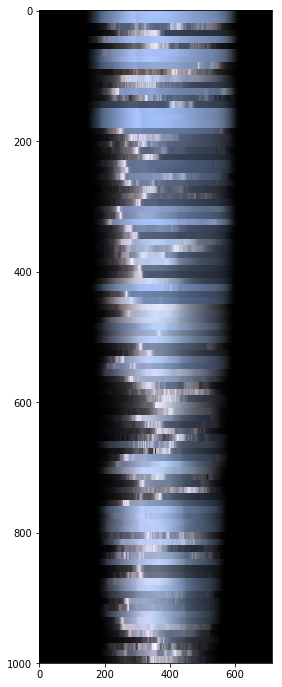

In [11]:
import gc
gc.collect()
import imageio

#plt.imshow(daysg)

days = decd

mpl.rcParams['figure.figsize'] = (24, 12)
daysn = days_raw/np.max(days_raw)
#img = Image.new('RGB', dcol, color = 'red')
imageio.imwrite('days-norm.png', (255*daysn).astype(np.uint8))
#img.save('pil_red.png')

plt.imshow(daysn,aspect=2)

C:\Users\foote\Anaconda2\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """


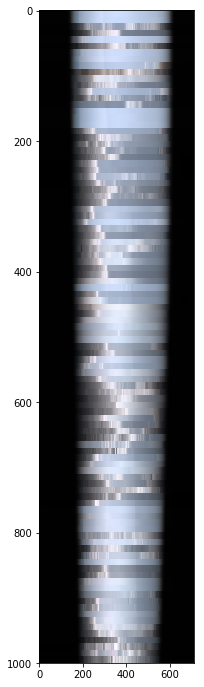

In [12]:
import imageio

import gc
gc.collect()
daysg = (daysn)**(1/2.0)
plt.imshow(daysg[:,:,:], aspect=3)
imageio.imwrite('days-gamma20.png', (255*daysg).astype(np.uint8))

#write_hdr(daysg, 'daysg20.hdr')

In [ ]:
# radial plot of grids for a particular day
import gc
gc.collect()
def getcolor(cmap, frac):
    """ go fraction into cmap and return a color triple """
    l, w = cmap.shape
    assert(w ==3)
    i = int(l*frac)
    if i >= l:
        i = l-1
    if i < 0:
        i = 0
    return cmap[i,:]
    

def mapr(r):
    """map radius into a fraction of a colormap, 0 < r < .707"""
    return(2*r)

# width and height of inner frames
width = 7000
height =7000

# with and height of grid, each grid element is a day
gwidth = 1
gheight = 1

out = np.zeros((gheight*height,gwidth*width,3),dtype=float)
#for day in [3, 4, 8, 12, 13]:
for day in [5, 9, 10, 11, 14 ]:
    gc.collect()
    froot = "day{}".format(day)
    for gw in range(gwidth):
        for gh in range(gheight):
    
            for w in range(width):
                for h in range(height):

                    x = (w - width/2)/float(width) 
                    y = (h - height/2)/float(height)
                    r = np.sqrt(x*x + y*y)
                    #th = np.arctan2(y,x)
                    #day = int(100*th*4/2*np.pi)
                    # want to show morning, so outside (max) is zero and inside (min) is 1/2
                    #print r
                    out[(gh*height) + h, (gw*width) + w] = getcolor(daysg[day*10,:,:],mapr(r))
                    #out[(gh*height) + h, (gw*width) + w] = getcolor(decd[dc,:,:],mapr(r))
            print gw, gh
    
    fname  = froot + ".png"
    imageio.imwrite(fname, (255*out).astype(np.uint8))
    print "saved " + fname
    #fig = plt.figure(frameon=False, figsize = (12,12))
    #plt.imshow(out)
    #plt.axis('off')  
    #fig.axes[0].get_xaxis().set_visible(False)
    #fig.axes[0].get_yaxis().set_visible(False)
        #plt.savefig('advance{:03d}.png'.format(i),bbox_inches='tight', pad_inches=0)
    gc.collect()
    write_hdr(out, froot + ".hdr")
    print "HDR saved"
    # to convert to gif with imagemagick
    #$ /cygdrive/c/Program\ Files/ImageMagick-7.0.5-Q16/convert.exe   -delay 7 -loop 0 frame*.png ani.gif
#ffmpeg -r 15 -f image2  -i frame%03d.png -vcodec libx264 -crf 25 -pix_fmt yuv420p  test.mp4


0 0
saved day5.png
HDR saved
0 0
saved day9.png
HDR saved
0 0
saved day10.png
HDR saved


In [13]:
# radial plots for summer of data
import gc
gc.collect()

def getcolor(cmap, frac):
    """ go fraction into cmap and return a color triple """
    l, w = cmap.shape
    assert(w ==3)
    i = int(l*frac)
    if i >= l:
        i = l-1
    if i < 0:
        i = 0
    return cmap[i,:]
    

def mapr(r):
    """map radius into a fraction of a colormap, 0 < r < .707"""
    return(2*r)

# width and height of inner frames


l, c = decd[0].shape

width = l
height = l

#width = 100
#height = 100

# with and height of grid, each grid element is a day
gwidth = 14
gheight = 7

out = np.zeros((gheight*height,gwidth*width,3),dtype=float)
dc = 2 
for gw in range(gwidth):
    for gh in range(gheight):
    
        for w in range(width):
            for h in range(height):

                x = (w - width/2)/float(width) 
                y = (h - height/2)/float(height)
                r = np.sqrt(x*x + y*y)
                #th = np.arctan2(y,x)
                #day = int(100*th*4/2*np.pi)
                # want to show morning, so outside (max) is zero and inside (min) is 1/2
                #print r
                #out[(gh*height) + h, (gw*width) + w] = getcolor(daysg[dc,:,:],mapr(r))
                out[(gh*height) + h, (gw*width) + w] = getcolor(decd[dc,:,:],mapr(r))
        dc += 1
        print gw, gh, dc
    
fname  = "griddo-widehdr.png"
imageio.imwrite(fname, (255*out).astype(np.uint8))
print "saved " + fname
#fig = plt.figure(frameon=False, figsize = (12,12))
#plt.imshow(out)
#plt.axis('off')  
#fig.axes[0].get_xaxis().set_visible(False)
#fig.axes[0].get_yaxis().set_visible(False)
        #plt.savefig('advance{:03d}.png'.format(i),bbox_inches='tight', pad_inches=0)

write_hdr(out, "griddo20.hdr")
    # to convert to gif with imagemagick
    #$ /cygdrive/c/Program\ Files/ImageMagick-7.0.5-Q16/convert.exe   -delay 7 -loop 0 frame*.png ani.gif
#ffmpeg -r 15 -f image2  -i frame%03d.png -vcodec libx264 -crf 25 -pix_fmt yuv420p  test.mp4
print "HDR saved"

0 0 3
0 1 4
0 2 5
0 3 6
0 4 7
0 5 8
0 6 9
1 0 10
1 1 11
1 2 12
1 3 13
1 4 14
1 5 15
1 6 16
2 0 17
2 1 18
2 2 19
2 3 20
2 4 21
2 5 22
2 6 23
3 0 24
3 1 25
3 2 26
3 3 27
3 4 28
3 5 29
3 6 30
4 0 31
4 1 32
4 2 33
4 3 34
4 4 35
4 5 36
4 6 37
5 0 38
5 1 39
5 2 40
5 3 41
5 4 42
5 5 43
5 6 44
6 0 45
6 1 46
6 2 47
6 3 48
6 4 49
6 5 50
6 6 51
7 0 52
7 1 53
7 2 54
7 3 55
7 4 56
7 5 57
7 6 58
8 0 59
8 1 60
8 2 61
8 3 62
8 4 63
8 5 64
8 6 65
9 0 66
9 1 67
9 2 68
9 3 69
9 4 70
9 5 71
9 6 72
10 0 73
10 1 74
10 2 75
10 3 76
10 4 77
10 5 78
10 6 79
11 0 80
11 1 81
11 2 82
11 3 83
11 4 84
11 5 85
11 6 86
12 0 87
12 1 88
12 2 89
12 3 90
12 4 91
12 5 92
12 6 93
13 0 94
13 1 95
13 2 96
13 3 97
13 4 98
13 5 99
13 6 100
saved griddo-widehdr.png
saved


In [ ]:
# radial plot

def getcolor(cmap, frac):
    """ go fraction into cmap and return a color triple """
    l, w = cmap.shape
    assert(w ==3)
    i = int(l*frac)
    if i >= l:
        i = l-1
    if i < 0:
        i = 0
    return cmap[i,:]
    

width = 400
height = 400
out = np.zeros((width,height,3),dtype=float)

offset = np.arange(-0.1,1.0, 0.002)
#offset =[0.]
for i, off in enumerate(offset):
    for w in range(width):
        for h in range(height):

            x = (w - width/2)/float(width) 
            y = (h - height/2)/float(height)
            r = np.sqrt(x*x + y*y)
            #th = np.arctan2(y,x)
            #day = int(100*th*4/2*np.pi)
            # want to show morning, so outside (max) is zero and inside (min) is 1/2
            out[h,w] = getcolor(daysg[1200],0.5*(1 + off -r))
        
        
    
    fname  = "frame{:03d}.png".format(i)
    imageio.imwrite(fname, (255*out).astype(np.uint8))
    print "saved " + fname
    if i ==0 :
        fig = plt.figure(frameon=False, figsize = (12,12))
        plt.imshow(out)
        plt.axis('off')  
        fig.axes[0].get_xaxis().set_visible(False)
        fig.axes[0].get_yaxis().set_visible(False)
        #plt.savefig('advance{:03d}.png'.format(i),bbox_inches='tight', pad_inches=0)
        print "saved"
    # to convert to gif with imagemagick
    #$ /cygdrive/c/Program\ Files/ImageMagick-7.0.5-Q16/convert.exe   -delay 7 -loop 0 frame*.png ani.gif
#ffmpeg -r 15 -f image2  -i frame%03d.png -vcodec libx264 -crf 25 -pix_fmt yuv420p  test.mp4


In [ ]:
# radial plot

def getcolor(cmap, frac):
    """ go fraction into cmap and return a color triple """
    l, w = cmap.shape
    assert(w ==3)
    i = int(l*frac)
    if i >= l:
        i = l-1
    if i < 0:
        i = 0
    return cmap[i,:]
    

width = 400
height = 400
out = np.zeros((width,height,3),dtype=float)

offset = np.arange(-0.1,1.0, 0.002)
#offset =[0.]
for i, off in enumerate(offset):
    for w in range(width):
        for h in range(height):

            x = (w - width/2)/float(width) 
            y = (h - height/2)/float(height)
            r = np.sqrt(x*x + y*y)
            #th = np.arctan2(y,x)
            #day = int(100*th*4/2*np.pi)
            # want to show morning, so outside (max) is zero and inside (min) is 1/2
            out[h,w] = getcolor(daysg[1200],0.5*(1 + off -r))
        
        
    
    fname  = "frame{:03d}.png".format(i)
    imageio.imwrite(fname, (255*out).astype(np.uint8))
    print "saved " + fname
    if i ==0 :
        fig = plt.figure(frameon=False, figsize = (12,12))
        plt.imshow(out)
        plt.axis('off')  
        fig.axes[0].get_xaxis().set_visible(False)
        fig.axes[0].get_yaxis().set_visible(False)
        #plt.savefig('advance{:03d}.png'.format(i),bbox_inches='tight', pad_inches=0)
        print "saved"
    # to convert to gif with imagemagick
    #$ /cygdrive/c/Program\ Files/ImageMagick-7.0.5-Q16/convert.exe   -delay 7 -loop 0 frame*.png ani.gif
#ffmpeg -r 15 -f image2  -i frame%03d.png -vcodec libx264 -crf 25 -pix_fmt yuv420p  test.mp4


In [ ]:
# radial plots

def getcolor(cmap, frac):
    """ go fraction into cmap and return a color triple """
    l, w = cmap.shape
    assert(w ==3)
    i = int(l*frac)
    if i >= l:
        i = l-1
    if i < 0:
        i = 0
    return cmap[i,:]
    

width = 1200
height = 1200
out = np.zeros((width,height,3),dtype=float)

for w in range(width):
    for h in range(height):

        x = (w - width/2)/float(width) 
        y = (h - height/2)/float(height)
        r = np.sqrt(x*x + y*y)
        th = np.arctan2(y,x)
        #print x, y, r
        #out[w,h,:] = [0, 0, 0]
        day = int(200*th*8/(2*np.pi))
        # want to show morning, so outside (max) is zero and inside (min) is 1/2
        out[h,w] = getcolor(daysg[day],0.5*(1-r))
        # want to show evening, so outside (max) is 1 and inside (min) is 1/2
        #out[h,w] = getcolor(days[200],1.2*(r + 1)/2)
        #out[h,w] = getcolor(days[200],r)
        
        
    

plt.figure(figsize = (12,12))
plt.imshow(out)
plt.axis('off')    
plt.savefig('radial4.png')

In [ ]:
# spiral plots
from PIL import Image, ImageDraw
im = Image.new('RGBA', (400, 400), (0, 255, 0, 0)) 
draw = ImageDraw.Draw(im) 
draw.line((100,200, 150,300), fill=128)
im.show()

def getcolor(cmap, frac):
    """ go fraction into cmap and return a color triple """
    l, w = cmap.shape
    assert(w ==3)
    i = int(l*frac)
    if i >= l:
        i = l-1
    if i < 0:
        i = 0
    return cmap[i,:]
    


In [ ]:
img.save('radialdays.png')

In [ ]:
def get_colors_for(c):
    red = c[:,1]
    grn = c[:,2]
    blu = c[:,3]

    mmax = np.max([np.max(red), np.max(blu), np.max(grn)])

    red = red/mmax
    grn = grn/mmax
    blu = blu/mmax


    colors = []
    for i, r in enumerate(red):
        colors.append(mpl.colors.to_rgb((red[i],grn[i],blu[i])))
    return colors

c = get_colors_for(newdata[0])


In [ ]:
newd = np.array(newd)
print newd.shape

In [ ]:
# make rectangular jpeg to wrap a sphere
import scipy.signal
from PIL import Image, ImageDraw

cmap = []
for d in newd[3:4]:
    print d.shape
    colors = d[:,1:4]
    # gamma correct
    colors = (colors / 65535.)**(1/2.2)
    colors = colors/np.max(colors)
    #colors = colors/mmax
    
    print colors.shape
    dcol =  scipy.signal.decimate(colors, 10, n=None, ftype='iir', axis=0, zero_phase=True)
    dcol_wide = np.multiply.outer(np.ones((1000)),dcol)
    cmap.extend(dcol_wide)
    
#dcol_wide = np.multiply.outer(np.ones((500)),dcol)
#dcol_wide = np.swapaxes(dcol_wide,1,2)
cmap = np.swapaxes(cmap,0,1)
cmap = np.array(cmap,dtype=float)
#print days.shape

#daysn = days/np.max(days)

#plt.imshow(cmap[1500:7500,:])
fig = plt.figure(frameon=False, figsize = (12,12))
plt.imshow(cmap[1500:7500,:])
plt.axis('off')  
fig.axes[0].get_xaxis().set_visible(False)
fig.axes[0].get_yaxis().set_visible(False)
plt.savefig('cmap.jpg',bbox_inches='tight', pad_inches=0)

In [ ]:
   fig = plt.figure(frameon=False, figsize = (12,12))
    plt.imshow(out)
    plt.axis('off')  
    fig.axes[0].get_xaxis().set_visible(False)
    fig.axes[0].get_yaxis().set_visible(False)
    plt.savefig('advance{:03d}.png'.format(i),bbox_inches='tight', pad_inches=0)